# Establish CAPEX estimation relationship for a boiler to generate steam

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import settings
from functions.general.utility import get_project_root
from functions.TEA import convert_currency_annual_average
from functions.TEA.scaling import CEPCI_scale
from functions.general.curve_fitting import func_straight_line
from scipy.optimize import curve_fit


### Load data and do some data wrangling

In [2]:
# General parameters
root_dir = get_project_root()
updated_currency = "GBP"
updated_CEPCI_year = 2020
plot_style = settings.plotting.digital
# Load and display data
data_file = "CAPEX_boiler.csv"
data_file_path = os.path.join(root_dir, "data", data_file)
df_source = pd.read_csv(data_file_path)
df = df_source.copy()  # working copy of original dataframe
df

,Process Reference,CAPEX,Currency,Plant size [kg steam/hour],Reference Year,Country,Scaling factor,Comments,Reference,Reference label,Ignore
0,Package steam boiler,464000,USD,50000,2005,USA,0.96,"for sizes 50,000-350,000","Chemical Process Design and Integration, Smith...",a,NaN
1,Field erected steam boiler,328000,USD,20000,2005,USA,0.81,"for sizes 10,000-800,000","Chemical Process Design and Integration, Smith...",a,NaN
2,Boiler,631000,USD,15866,2011,USA,NaN,converted to kg Steam/hour by converting MM BT...,Analysis of the Production Cost for Various Gr...,b,NaN
3,Boiler,309000,USD,3003,2011,USA,NaN,converted to kg Steam/hour by converting MM BT...,Analysis of the Production Cost for Various Gr...,b,NaN
4,Boiler,1088000,USD,637253,2011,USA,NaN,converted to kg Steam/hour by converting MM BT...,Analysis of the Production Cost for Various Gr...,b,True


In [3]:
# Convert all values to same currency and update to most recent CEPCI value
CAPEX_currency_scaled = []
CAPEX_currency_CEPCI_scaled = []

for row_no in df.index:
    CAPEX_currency_scaled.append(
        convert_currency_annual_average(value=df["CAPEX"][row_no], year=df["Reference Year"][row_no],
                                        base_currency=df["Currency"][row_no], converted_currency=updated_currency, 
                                        approximate_rate=True, method="yfinance"))
    CAPEX_currency_CEPCI_scaled.append(
        CEPCI_scale(base_year=df["Reference Year"][row_no], design_year=updated_CEPCI_year,
                    value=CAPEX_currency_scaled[row_no]))

# Add (i) currency and (ii) currency + CEPCI scaled values to dataframe
currency_scaled_label = "CAPEX_" + updated_currency
currency_and_CEPCI_scaled_label = "CAPEX_" + updated_currency + "_CEPCI_" + str(updated_CEPCI_year)

df[currency_scaled_label] = CAPEX_currency_scaled
df[currency_and_CEPCI_scaled_label] = CAPEX_currency_CEPCI_scaled

# Also add to original dataframe
df_source[currency_scaled_label] = CAPEX_currency_scaled
df_source[currency_and_CEPCI_scaled_label] = CAPEX_currency_CEPCI_scaled

df

,Process Reference,CAPEX,Currency,Plant size [kg steam/hour],Reference Year,Country,Scaling factor,Comments,Reference,Reference label,Ignore,CAPEX_GBP,CAPEX_GBP_CEPCI_2020
0,Package steam boiler,464000,USD,50000,2005,USA,0.96,"for sizes 50,000-350,000","Chemical Process Design and Integration, Smith...",a,NaN,255307.669084,325814.464497
1,Field erected steam boiler,328000,USD,20000,2005,USA,0.81,"for sizes 10,000-800,000","Chemical Process Design and Integration, Smith...",a,NaN,180476.110904,230317.121455
2,Boiler,631000,USD,15866,2011,USA,NaN,converted to kg Steam/hour by converting MM BT...,Analysis of the Production Cost for Various Gr...,b,NaN,393570.193597,401499.386502
3,Boiler,309000,USD,3003,2011,USA,NaN,converted to kg Steam/hour by converting MM BT...,Analysis of the Production Cost for Various Gr...,b,NaN,192730.887197,196613.804166
4,Boiler,1088000,USD,637253,2011,USA,NaN,converted to kg Steam/hour by converting MM BT...,Analysis of the Production Cost for Various Gr...,b,True,678612.314791,692284.203667


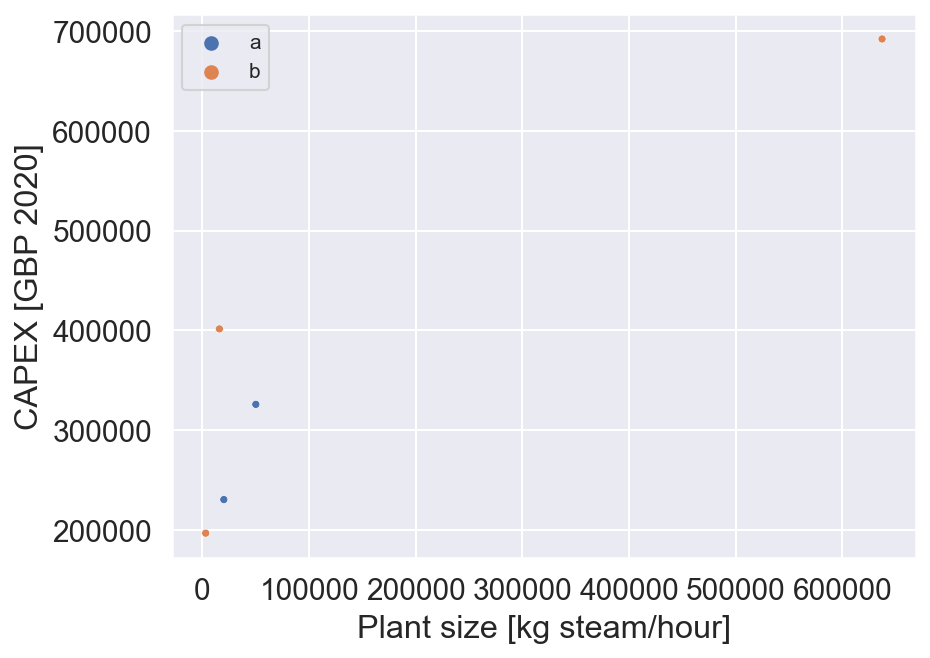

In [4]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
sns.scatterplot(data=df, x="Plant size [kg steam/hour]", y="CAPEX_GBP_CEPCI_2020", hue="Reference label", s=15)
ax.set_ylabel("CAPEX [GBP 2020]")
plt.legend(loc='upper left', fontsize=10)
plt.show()

- 1 data point for much larger systems than the other 3 - reject that one. 
- 3 of the other 4 data points form a straight line
- Base model on those 3 and reject outlier

In [5]:
df_clean = df.drop([2,4])
df_clean

# Note could alternatively also filter like this:
# df = df[df["CAPEX"] < 500000]

,Process Reference,CAPEX,Currency,Plant size [kg steam/hour],Reference Year,Country,Scaling factor,Comments,Reference,Reference label,Ignore,CAPEX_GBP,CAPEX_GBP_CEPCI_2020
0,Package steam boiler,464000,USD,50000,2005,USA,0.96,"for sizes 50,000-350,000","Chemical Process Design and Integration, Smith...",a,NaN,255307.669084,325814.464497
1,Field erected steam boiler,328000,USD,20000,2005,USA,0.81,"for sizes 10,000-800,000","Chemical Process Design and Integration, Smith...",a,NaN,180476.110904,230317.121455
3,Boiler,309000,USD,3003,2011,USA,NaN,converted to kg Steam/hour by converting MM BT...,Analysis of the Production Cost for Various Gr...,b,NaN,192730.887197,196613.804166


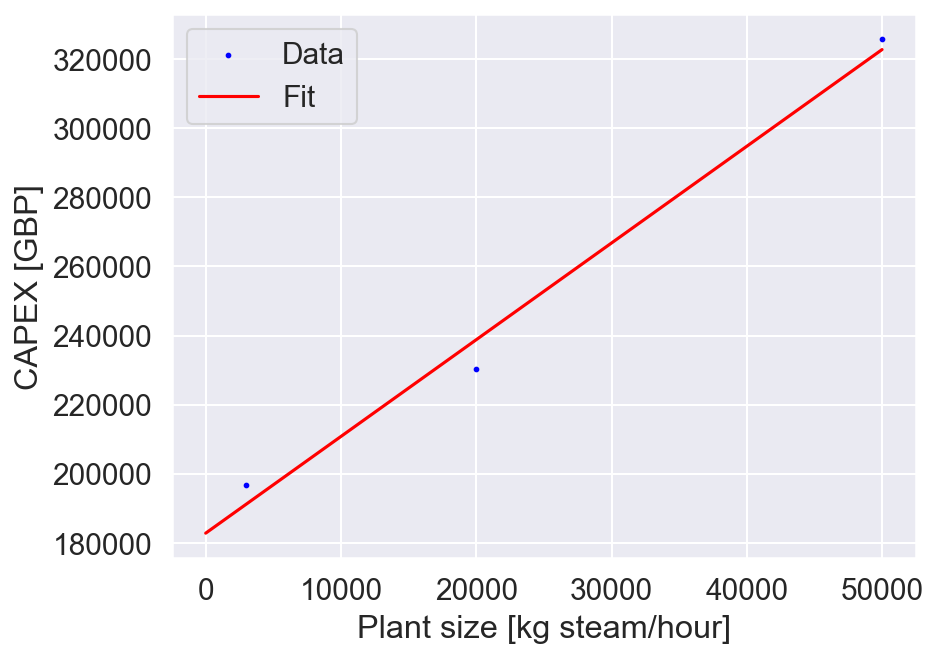

In [6]:
# Display data and fit in same plot
x_array =np.linspace(start=0, stop=50000, num=100)


optimised_constants_straight_line, _ = curve_fit(func_straight_line, 
                                                 df_clean["Plant size [kg steam/hour]"],
                                                 df_clean["CAPEX_GBP_CEPCI_2020"])
y_fit_straight_line_data_range = func_straight_line(x_array, *optimised_constants_straight_line)

fig, ax = plt.subplots(figsize=tuple(plot_style.fig_size), dpi=150)
ax.scatter(df_clean["Plant size [kg steam/hour]"], df_clean["CAPEX_GBP_CEPCI_2020"], label="Data", color="blue", s=3)
ax.plot(x_array, func_straight_line(x_array, *optimised_constants_straight_line), label="Fit", color="red")

ax.set_xlabel("Plant size [kg steam/hour]")
ax.set_ylabel("CAPEX [GBP]")
plt.legend()
plt.show()


- Linear fit represents the data well.
- Very small systems may be overestimated... 
    - Take an approach of scaling from smallest data point for systems smaller than 2000 kg Steam/hour

In [21]:
from functions.TEA import power_scale
# Extract the smallest value like this
smallest_system_data = (df_clean[df_clean["Plant size [kg steam/hour]"] == df_clean["Plant size [kg steam/hour]"].min()])
smallest_system_cost = smallest_system_data[currency_and_CEPCI_scaled_label]
smallest_system_size = smallest_system_data["Plant size [kg steam/hour]"]

example_100_scaled_cost = power_scale(baseline_size=float(smallest_system_size),
                                      design_size=100,
                                      baseline_cost=smallest_system_cost,
                                      scaling_factor=0.8)
print(f"Smallest system size: {float(smallest_system_size)}")
print(f"Smallest system cost: {float(smallest_system_cost)}")
print(f"Scaled size at 100 kg Steam/hour {float(example_100_scaled_cost)}")



Smallest system size: 3003.0
Smallest system cost: 196613.80416647217
Scaled size at 100 kg Steam/hour 12929.143045411822


# Conclusions
- Reasonably good approach.
- Really lacking data for very small scale systems...